# Tutorial 2: Simulated Data (Different Noise Levels and Combinations)

In this tutorial, we assess the DCCAE module's ability to identify nonlinear correlations among omics modalities while filtering out modality-specific noise. We utilize **Simulated Dataset 2 (Different Noise Levels and Combinations)**. Four distinct noise combinations are created by introducing Gaussian noise and pepper noise ("dropout" events). These combinations are generated by applying the two noise types to modalities in all possible configurations. Additionally, three noise levels are applied to both modalities. The spatial coordinates derived from the arc spatial pattern serve as the spatial information across all noise combinations.

All datasets used in this paper are available at https://doi.org/10.5281/zenodo.14854747.

## Loading package

In [1]:
import warnings
warnings.filterwarnings('ignore')
import torch
import scanpy as sc
import numpy as np
from sklearn.metrics.cluster import adjusted_rand_score
import anndata as ad
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix

import os
## Should be replaced with the R package installation path
os.environ['R_HOME'] = 'E:/R-4.3.1'
os.environ['R_USER'] = 'E:/anaconda/lib/site-packages/rpy2'

import sys
sys.path.append(r'..')
from Model.INR import INRModel
from Model.utils import mclust_R, reorder_categories
from Model.model import DCCAE
from Model.preprocess import fix_seed
fix_seed(2024)

## Loading data
We need to load the simulated data and expand it to a suitable dimension so that we can store the results.

When selecting data, we need to specify two parameters, 'replicate' and 'noise_level', which have the following meanings:
- replicate: representing different noise combinations (1-Gaussian+Gaussian, 2-Gaussian+pepper, 3-pepper+Gaussian, and 4-pepper+pepper);
- noise_level: representing the degree of noise added (0-original, 1-low, 2-medium, 3-high).

In [2]:
replicate = 1
file_fold_1 = f'../Data/Noise_Combination_{replicate}/Combination{replicate}_RNA'
file_fold_2 = f'../Data/Noise_Combination_{replicate}/Combination{replicate}_Protein'

adata_omics_1 = sc.read_h5ad(file_fold_1 + '.h5ad')
adata_omics_2 = sc.read_h5ad(file_fold_2 + '.h5ad')

noise_level = 1
adata_omics_1.X = adata_omics_1.obsm[f'level_{noise_level}']
adata_omics_2.X = adata_omics_2.obsm[f'level_{noise_level}']

sc.pp.pca(adata_omics_1, use_highly_variable=False)
sc.pp.pca(adata_omics_2, use_highly_variable=False)

adata_RNA = adata_omics_1.copy()
adata_ADT = adata_omics_2.copy()

## Training the model

### INR module
This module aims to capture diverse spatial patterns while ensuring spatial continuity from spatial information. In this module, spatial coordinates serve as inputs to a neural network employing three sine periodic activation functions to reconstruct each omics modality. This reconstruction process is further enhanced with kernel functions to bolster continuous representation capabilities.

By treating spatial information as prior knowledge rather than a standalone modality, the INR module learns continuous spatial patterns of omics modalities. This design enables the INR module to accommodate diverse combinations of modalities across varying dimensions, ranging from raw features or reduced-dimension embeddings.

In [ ]:
## INR module training
def Spatially_Continuous_Reconstruction(adata, epoch_num):
    coords = adata.obsm['spatial'].astype(np.float32)
    node_feats = adata.X.astype(np.float32)

    coords = torch.from_numpy(coords).float()
    if isinstance(node_feats, csr_matrix):
        node_feats = node_feats.toarray()
    node_feats = torch.from_numpy(node_feats).float()
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    node_feats = node_feats.to(device)
    coords = coords.to(device)
    
    print(f'out_dim: {node_feats.shape[1]}')

    model = INRModel(
        X=node_feats,
        spatial_coord=coords,
        device=device,
        learning_rate=1e-4,
        reg_par=0,
        epoch_num=epoch_num,
        bandwidth=0.02,
        print_train_log_info=True
    )

    reconstructed_X = model.fit()
    if f'INR_level_{noise_level}' not in adata.uns:
        adata.uns[f'INR_level_{noise_level}'] = reconstructed_X

# modality 1
Spatially_Continuous_Reconstruction(adata_omics_1, 500)

# modality 2
Spatially_Continuous_Reconstruction(adata_omics_2, 500)

In [ ]:
## Run PCA on the spatially continuous reconstructions of 2 modalities
adata_omics_1.X = adata_omics_1.uns[f'INR_level_{noise_level}']
adata_omics_2.X = adata_omics_2.uns[f'INR_level_{noise_level}']

sc.tl.pca(adata_RNA, use_highly_variable=False)
sc.tl.pca(adata_ADT, use_highly_variable=False)

### DCCAE module
This module focuses on capturing the nonlinear correlations among omics modalities while eliminating modality-specific noise. In the DCCAE module, the spatially reconstructed continuous omics data serve as input and the CCA Loss as well as the Reconstruction Loss are jointly optimized for model training. Finally, the feature transformation is performed through a linear CCA layer. This design enables the capture of deep nonlinear relationships among omics modalities while preserving their individual characteristics, and facilitates pairwise interaction of the integrated embeddings.

In [56]:
n_DCCAE = 10  # number of components for DCCAE

# Get the feature sizes of the two datasets
features1 = adata_RNA.obsm['X_pca'].shape[1]  
features2 = adata_ADT.obsm['X_pca'].shape[1]  

# Define the structure of the hidden layers and output size for the two modalities
layers1 = [256, 256, n_DCCAE]  
layers2 = [256, 256, n_DCCAE]  

# Load the PCA features from the two datasets
X = adata_RNA.obsm['X_pca'].copy()  
Y = adata_ADT.obsm['X_pca'].copy()  

# Specify the representations to be used
use_rep = ['DCCAE_X', "DCCAE_Y", "DCCAE"]  

# Set the number of training epochs
epochs = 300  

# Initialize the DCCAE model with specified parameters
dccae = DCCAE(
    input_size1=features1,  # Input size for the first modality
    input_size2=features2,  # Input size for the second modality
    n_components=n_DCCAE,    # Number of components for DCCAE
    layer_sizes1=layers1,   # Hidden layer sizes for the first modality
    layer_sizes2=layers2,   # Hidden layer sizes for the second modality
    epoch_num=epochs,       # Number of training epochs
    learning_rate=0.001     # Learning rate for training
)

# Train the DCCAE model using the two datasets X and Y
dccae.fit([X, Y])  

# Transform the input data using the trained DCCAE model
Xs_transformed = dccae.transform([X, Y])  

# Assign the transformed features to the AnnData objects
adata_RNA.obsm["DCCAE_X"] = Xs_transformed[0]  
adata_ADT.obsm["DCCAE_Y"] = Xs_transformed[1]  

# Concatenate the transformed features from both modalities
adata_RNA.obsm["DCCAE"] = np.concatenate(
    (adata_RNA.obsm["DCCAE_X"], adata_ADT.obsm["DCCAE_Y"]),
    axis=1
)

Training Progress: 100%|██████████| 300/300 [00:29<00:00, 10.25it/s]

model training finished!


## Storing the results

In [ ]:
adata_0 = ad.AnnData(obs=adata_RNA.obs[['clusters_mclust', 'noise_level']], obsm={'SpaKnit': adata_RNA.obsm['DCCA']})
adata_1 = ad.AnnData(obs=adata_RNA.obs[['clusters_mclust', 'noise_level']], obsm={'SpaKnit': adata_RNA.obsm['DCCA']})
adata_2 = ad.AnnData(obs=adata_RNA.obs[['clusters_mclust', 'noise_level']], obsm={'SpaKnit': adata_RNA.obsm['DCCA']})
adata_3 = ad.AnnData(obs=adata_RNA.obs[['clusters_mclust', 'noise_level']], obsm={'SpaKnit': adata_RNA.obsm['DCCA']})
adata_results = adata_0.concatenate(adata_1, adata_2, adata_3, batch_key='noise_level')

obs_df = adata_results.obs
obs_df = obs_df.rename(columns={'clusters_mclust': 'SpaKnit'})
adata_results.obs = obs_df

results = sc.read_h5ad(f'./Results/Noise_Combination_{replicate}.h5ad')
results.obs['SpaKnit'] = adata_results.obs['SpaKnit'].values
results.obsm['SpaKnit'] = adata_results.obsm['SpaKnit']
results.write_h5ad(f'./Results/Noise_Combination_{replicate}.h5ad')

AnnData object with n_obs × n_vars = 4800 × 0
    obs: 'Ground Truth', 'noise_level', 'SpaGCN', 'SpatialGlue', 'MultiMAP', 'STAGATE', 'Modality1', 'Modality2', 'SpaKnit'
    obsm: 'Modality1', 'Modality2', 'MultiMAP', 'STAGATE', 'SpatialGlue', 'spatial', 'SpaKnit'

## Visualizing results
We visualize the results for each noise combination (using noise level 1 as an example)

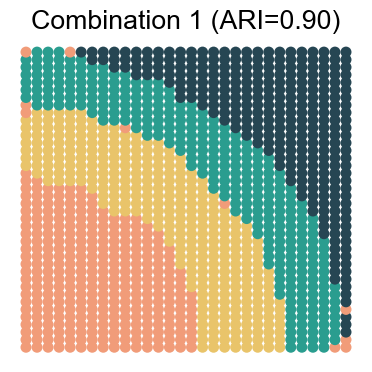

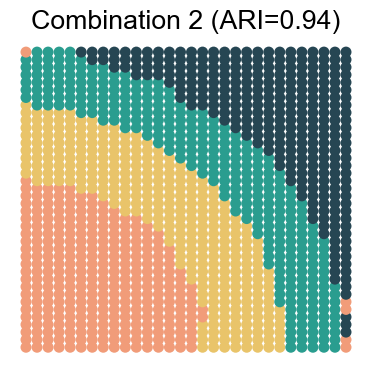

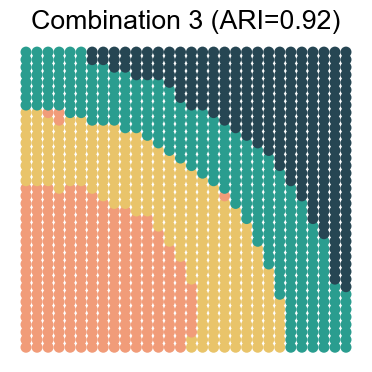

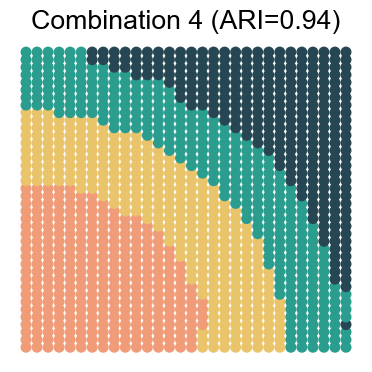

In [ ]:
# Define new_orders for each replicate
new_order_dict = {
    1: [1, 2, 3, 4],
    2: [2, 3, 1, 4],
    3: [1, 2, 3, 4],
    4: [1, 2, 3, 4]
}

colors_domain = [
    '#f19c79', '#e9c46a', '#2a9d8f', '#264653'
]

plt.rcParams['font.size'] = 16
plt.rcParams['font.sans-serif'] = ['Arial']

# Loop through each replicate
for replicate in [1, 2, 3, 4]:
    # Load the Results
    adata_analysis = sc.read_h5ad(f'./Results/Noise_Combination_{replicate}.h5ad')
    
    # Select noise level 1
    noise_level = 1  # 0, 1, 2, 3
    adata_analysis = adata_analysis[adata_analysis.obs['noise_level']==noise_level]
    
    # Reorder categories based on the replicate's new_order
    new_order = new_order_dict[replicate]
    method = 'SpaKnit'
    reorder_categories(adata_analysis, method, new_order)
    
    # Calculate ARI
    ari_value = adjusted_rand_score(adata_analysis.obs['Ground Truth'], adata_analysis.obs[method])
    
    # Create figure
    fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    
    # Plot the spatial embedding
    sc.pl.embedding(
        adata_analysis,
        basis='spatial',
        color=[method],
        title=None,
        s=250,
        colorbar_loc=None,
        show=False,
        ax=ax,
        palette=colors_domain,
        legend_loc=None
    )
    
    # Set title with ARI value
    ax.set_title(f"Combination {replicate} (ARI={ari_value:.2f})")
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    # Hide axis borders
    for spine in ax.spines.values():
        spine.set_visible(False)
    
    # Adjust subplot parameters
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
    plt.tight_layout()
    plt.show()